In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil import parser
from scipy.signal import spectrogram

In [2]:
train_series = pd.read_parquet('./sleep_institute_data/train_series.parquet')
train_events = pd.read_csv('./sleep_institute_data/train_events.csv')
print

<function print>

In [36]:
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [4]:
train_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## General information

In [4]:
# Size of data
print('train_seires contains ' + str(train_series.shape[0]) + ' rows')
print('train_events contains ' + str(train_events.shape[0]) + ' rows')

# Number of unique subjects
series_subject_ids = train_series.series_id.unique()
event_subject_ids = train_events.series_id.unique()
print('Number of unique sleep series: ' + str(event_subject_ids.shape[0]))
if series_subject_ids.shape[0] == event_subject_ids.shape[0]:
    print('Number of subjects in train_series and event_series are equivalent')

# Total number of seconds across all series
print('Total days in all series ' + str(train_series.shape[0]*5/86400))

train_seires contains 127946340 rows
train_events contains 14508 rows
Number of unique sleep series: 277
Number of subjects in train_series and event_series are equivalent
Total days in all series 7404.302083333333


## Distribution information

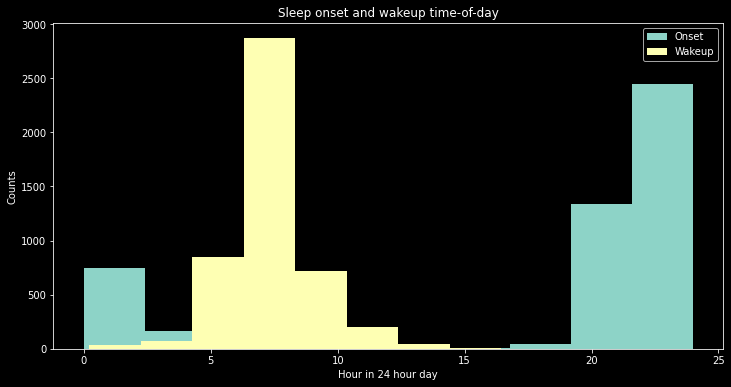

Number of unlabeled onset events: 2463
Number of unlabeled wakeup events: 2460


In [5]:
# Time of day sleep onset and wakeup
onset_timestamps = train_events[train_events['event'] == 'onset'].timestamp.to_numpy()
onset_timestamps = list(stamp for stamp in onset_timestamps)
onset_TOD_hour = []

wake_timestamps = train_events[train_events['event'] == 'wakeup'].timestamp.to_numpy()
wake_timestamps = list(stamp for stamp in wake_timestamps)
wake_TOD_hour = []

sleep_duration = []

num_onset_nans = 0
num_wake_nans = 0
for i in range(len(onset_timestamps)):
    
    if type(onset_timestamps[i]) == str:
        parsed_onset = parser.parse(onset_timestamps[i])
        onset_hour = parsed_onset.hour
        onset_minute = parsed_onset.minute / 60
        onset_second = parsed_onset.second / 3600
        onset_TOD_hour.append(onset_hour + onset_minute + onset_second)

    else:
        num_onset_nans += 1

    if type(wake_timestamps[i]) == str:
        parsed_wakeup = parser.parse(wake_timestamps[i])
        wake_hour = parsed_wakeup.hour
        wake_minute = parsed_wakeup.minute / 60
        wake_second = parsed_wakeup.second / 3600
        wake_TOD_hour.append(wake_hour + wake_minute + wake_second)

    else:
        num_wake_nans += 1

    if type(onset_timestamps[i]) == str and type(wake_timestamps[i]) == str:
        duration = parsed_wakeup - parsed_onset
        sleep_duration.append(duration.seconds/3600)



plt.figure(figsize=(12,6))
plt.title('Sleep onset and wakeup time-of-day')
plt.hist(np.array(onset_TOD_hour), label='Onset')
plt.hist(np.array(wake_TOD_hour), label='Wakeup')
plt.xlabel('Hour in 24 hour day')
plt.ylabel('Counts')
plt.legend()
plt.show()
plt.close()

print('Number of unlabeled onset events: ' + str(num_onset_nans))
print('Number of unlabeled wakeup events: ' + str(num_wake_nans))

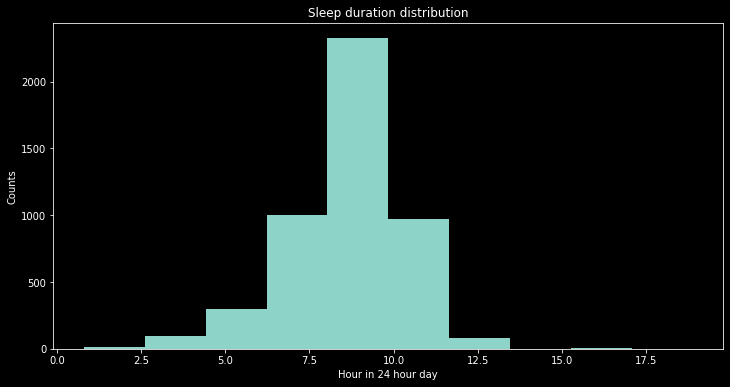

In [6]:
## Distribution of sleep duration
plt.figure(figsize=(12,6))
plt.title('Sleep duration distribution')
plt.hist(np.array(sleep_duration))
plt.xlabel('Hour in 24 hour day')
plt.ylabel('Counts')
plt.show()
plt.close()

In [15]:
# Lengths of each series in hours
series_duration = []
for id in train_series.series_id:
    beginning = parser.parse(train_series[id])

KeyError: '038441c925bb'

## Examine single series

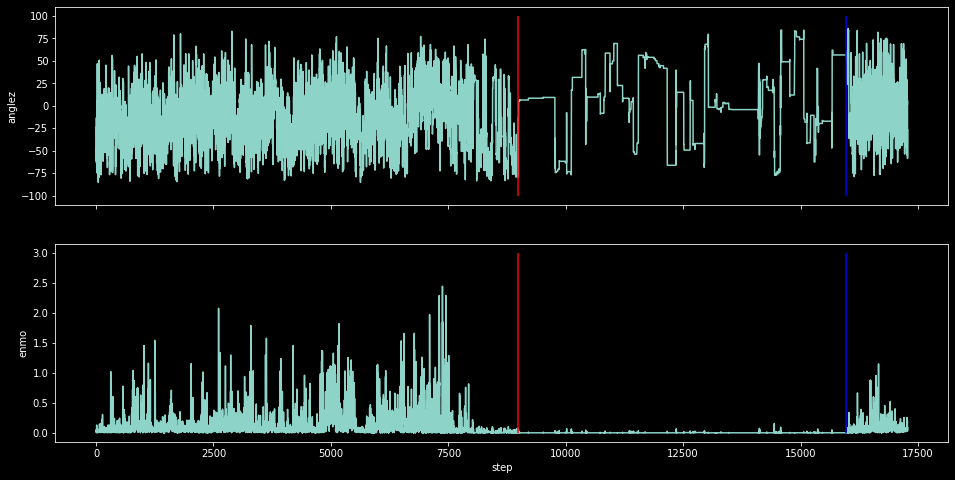

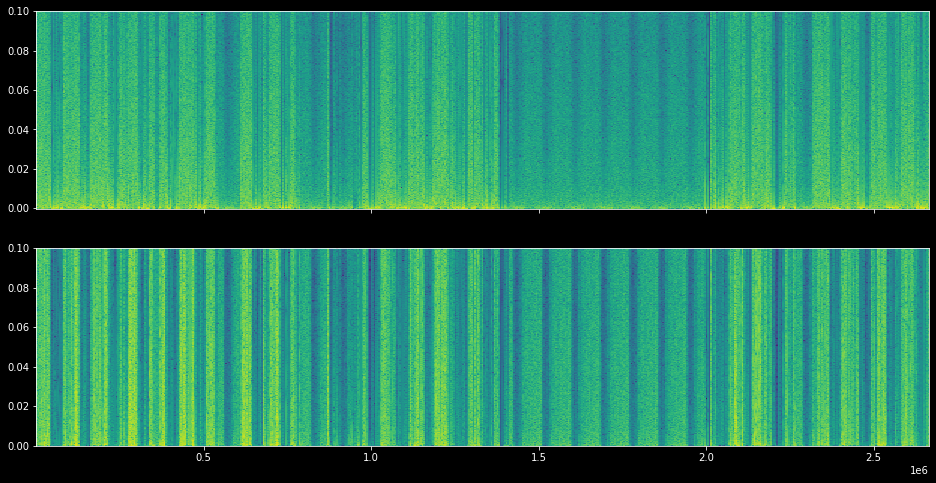

(513, 595)
30.90625


In [21]:
series_choice = 'ece2561f07e9'
series_df = train_series[train_series['series_id'] == series_choice]
series_step = series_df.step.to_numpy()
series_anglez = series_df.anglez.to_numpy()
series_enmo = series_df.enmo.to_numpy()

event_df = train_events[train_events['series_id'] == series_choice]
onset_steps = np.array(event_df[event_df['event'] == 'onset'].step)
wakeup_steps = np.array(event_df[event_df['event'] == 'wakeup'].step)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))

ax1.plot(series_step[0:17280], series_anglez[0:17280])
ax1.vlines(onset_steps[0], -100, 100, colors='r', label='onset')
ax1.vlines(wakeup_steps[0], -100, 100, colors='b', label='wakeup')
ax1.set_ylabel('anglez')

ax2.plot(series_step[0:17280], series_enmo[0:17280])
ax2.vlines(onset_steps[0], 0, 3, colors='r')
ax2.vlines(wakeup_steps[0], 0, 3, colors='b')
ax2.set_xlabel('step')
ax2.set_ylabel('enmo')

plt.show()
plt.close()


anglez_freq, anglez_time, anglez_spec = spectrogram(series_anglez, fs=1/5, nperseg=1024, window='hann')
enmo_freq, enmo_time, enmo_spec = spectrogram(series_enmo, fs=1/5, nperseg=1024, window='hann')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))

ax1.pcolormesh(anglez_time, anglez_freq, np.log(anglez_spec))
# ax1.set_ylabel('anglez freq')

ax2.pcolormesh(enmo_time, enmo_freq, np.log(enmo_spec))
# ax2.set_xlabel('step')
# ax2.set_ylabel('enmo')
plt.colorbar

plt.show()
plt.close()

print(enmo_spec.shape)
print(series_step.shape[0]/17280)